# Imports 

Based on kernel
https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet 

In [30]:
import torch # base
import numpy as np
from pathlib import Path # look in folders
import pandas as pd
import pydicom # open dicom images
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact
from glob import glob
from sklearn.model_selection import train_test_split
import random
import pytorch_tools as pt # core functionality
from pytorch_tools.utils.rle import rle_to_string, rle_decode, rle_encode
import utils # competition specific functions
# Some notebooks magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

SEED=123

In [2]:
## Initial setup
# !pip install kaggle
# !kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data
# !mkdir data
# !cp ./siim-acr-pneumothorax-segmentation-data.zip ./data/
# unzip -a ./data/siim-acr-pneumothorax-segmentation-data.zip

In [11]:
# Data
data = Path("./data")
train_rle_path = data / "train-rle.csv"
train_data_folder = data / "dicom-images-train"
test_data_folder = data / "dicom-images-test"
train_files_path = [x.as_posix() for x in sorted(train_data_folder.glob("./*/*/*.dcm"))]
test_files_path = [x.as_posix() for x in sorted(test_data_folder.glob("./*/*/*.dcm"))]
print(f"Train dataset length {len(train_files_path)}, test dataset length {len(test_files_path)}")
utils.show_dicom_info(random.sample(train_files_path))

Train dataset length 10712, test dataset length 1377


In [14]:
# load rles
rles = np.genfromtxt(train_rle_path, delimiter=', ', dtype=str)[1:]
print(len(rles)) # we have more rles than images. lets merge them

# new_rles = []
# for un_idx in tqdm(np.unique(rles[:, 0])):
#     idx_rles = rles[rles[:,0] == un_idx][:, 1]
#     masks = [rle_decode(rle, (1024,1024), relative=True) for rle in idx_rles]
#     mask = np.clip(np.sum(masks, axis=0), 0,1)
#     new_rle = rle_to_string(rle_encode(mask))
#     new_rle = new_rle if new_rle else '-1'
#     new_rles.append(new_rle)

train_rle_filtered_path = data / "train-rle-filtered.csv"

# with open(train_rle_filtered_path, 'w') as f:
#     lines = [', '.join([idx, rle]) for idx, rle in zip(np.unique(rles[:, 0]), new_rles)]
#     result = '\n'.join(lines)
#     f.write(result)
rles_filtered_df = pd.read_csv(train_rle_filtered_path)
# the second column has a space at the start, so manually giving column name
rles_filtered_df.columns = ['ImageId', 'EncodedPixels']
print(len(rles_filtered_df)) # Now we have less rles than images, it's OK (see kaggle discussions)

11582
10674


In [24]:
import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
rles = np.genfromtxt(train_rle_filtered_path, delimiter=', ', dtype=str)
@interact(n=(0,20))
def f(n=4, show_mask=True, use_clahe=False, dilate_mask=False):
    dataset = pydicom.dcmread(train_files_path[n])
    #show_dcm_info(dataset)
    plt.figure(figsize=(8,8))
    pixels = dataset.pixel_array
    if use_clahe:
        pixels = clahe.apply(pixels)
    plt.imshow(pixels, cmap=plt.cm.bone)
    img_id = train_files_path[n].split('/')[-1][:-4]
    try:
        rle_mask = rles[rles[:,0] == img_id][0, 1]
    except:
        rle_mask = '-1'
    if rle_mask != '-1':
        plt.title('Has pneumothorex')
        mask = rle_decode(rle_mask, (1024,1024)).astype(np.uint8)
        if show_mask:
            if dilate_mask:
                mask_sz = np.sqrt(np.sum(mask))
                k_sz = int(mask_sz * 0.1)
                kernel = np.ones((k_sz, k_sz))
                mask = cv2.dilate(mask,kernel,iterations = 1)
            pixels[mask == 1] = 255
            plt.imshow(pixels, cmap=plt.cm.bone)
        has_pneumothorex = True
    else:
        plt.title('No pneumothorex')
        has_pneumothorex = False
        
        # label the x-ray with information about the patient
    plt.text(0,0,'Age:{}, Sex: {}, Pneumothorax: {}'.format(int(dataset.PatientAge), 
                                                             dataset.PatientSex,
                                                             has_pneumothorex),
                           size=20,color='white', backgroundcolor='black')
    
    plt.show()

interactive(children=(IntSlider(value=4, description='n', max=20), Checkbox(value=True, description='show_mask…

Total images: 10675. Has masks: 2379
Max mask/image perc: 15.394306182861328. Min: 0.005245208740234375. Mean: 1.3680423994733788.


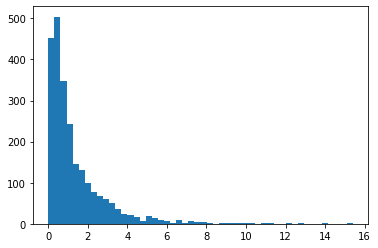

In [25]:
def get_mask_size(rles):
    sizes = []
    for rle in rles:
        if rle == '-1':
            sizes.append(0)
            continue
        sizes.append(sum([int(ii) for ii in rle.split()[1::2]]))
    return sizes

with_mask = rles[rles[:,1] != '-1']
print('Total images: {}. Has masks: {}'.format(len(rles), len(with_mask)))
mask_sizes = get_mask_size(rles[:, 1])
mask_sizes = [i / (1024*1024)*100 for i in mask_sizes if i > 0]
print('Max mask/image perc: {}. Min: {}. Mean: {}.'.format(max(mask_sizes),min(mask_sizes), np.mean(mask_sizes)))
plt.hist(mask_sizes, bins=50);

In [31]:
train, val_test = train_test_split(rles, stratify=rles[:,1] != '-1', test_size=0.2, random_state=SEED)
val, test = train_test_split(val_test, stratify=val_test[:,1] != '-1', test_size=0.5, random_state=SEED)
train_idx = set(train[:,0])
val_idx = set(val[:,0])
test_idx = set(test[:,0])
np.save(data / 'train_idx', train[:,0])
np.save(data / 'test_idx', test[:,0])
np.save(data / 'val_idx', val[:,0])

In [32]:
# save train images
Path.mkdir(data / 'preprocessed_train/images/', exist_ok=True, parents=True)
Path.mkdir(data / 'preprocessed_train/masks/', exist_ok=True, parents=True)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
USE_CLAHE = False
DILATE_MASK = False

In [36]:
def save_one(pair):
    idx, dcm = pair
    #filename = '{:06d}.'.format(idx)
    img = pydicom.dcmread(dcm).pixel_array
    img_id = dcm.split('/')[-1][:-4]
    try:
        rle_mask = rles[rles[:,0] == img_id][0, 1]
    except:
        rle_mask = '-1'
    if rle_mask == '-1':
        mask = np.zeros((1024,1024),dtype=np.uint8)
    else:
        #print(rle_mask)
        mask = rle_decode(rle_mask, (1024,1024)).astype(np.uint8)
    #print(np.mean(mask))
    # make images more contrast
    img = clahe.apply(img) if USE_CLAHE else img
    # make masks bigger for easier detection
    if DILATE_MASK:
        mask_sz = np.sqrt(np.sum(mask))
        k_sz = int(mask_sz * 0.05) # dilate by 5% of mask size
        kernel = np.ones((k_sz, k_sz))
        mask = cv2.dilate(mask,kernel,iterations = 1)
    cv2.imwrite(str(data / 'preprocessed_train/images/')+img_id + '.jpg', img)
    cv2.imwrite(str(data / 'preprocessed_train/masks/')+img_id + '.png', mask) #PNG for masks!

from multiprocessing import Pool
pairs = list(zip(list(range(len(train_files_path))), train_files_path))
with Pool() as pool:
    for _ in tqdm(pool.imap_unordered(save_one, pairs), total=len(pairs)):
        pass

In [ ]:
# save test images
os.makedirs('workdir/test/images', exist_ok=True)
for idx, dcm in enumerate(tqdm(test_files_path)):
    filename = '{:06d}.png'.format(idx)
    img = pydicom.dcmread(dcm).pixel_array
    cv2.imwrite(str(data / 'preprocessed_test/images/'+filename, img)